# Import packages and modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Datasets

In [ ]:
# Mount data
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read files
ecom_df_original = pd.read_excel('/content/drive/MyDrive/Module Projects/Python/ecommerce_retail_data.xlsx', sheet_name='E-Commerce Retail')
segment_def_df_original = pd.read_excel('/content/drive/MyDrive/Module Projects/Python/ecommerce_retail_data.xlsx', sheet_name='Segmentation')

In [ ]:
# Copy df
ecom_df = ecom_df_original.copy()
segment_def_df = segment_def_df_original.copy()

# Validate data

## Check nulls and data types

In [ ]:
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Kết luận: Columns `Description` và `CustomerID` đang null. Dtypes từng column phù hợp.

### Check `InvoiceNo`

In [ ]:
# Check từng dtype trong col InvoiceNo
ecom_df['InvoiceNo'].apply(type).value_counts()

,count
InvoiceNo,
<class 'int'>,532618
<class 'str'>,9291


In [ ]:
## Những giao dịch bị hủy, bắt đầu bằng 'C'
len(ecom_df[ecom_df['InvoiceNo'].str.startswith('C', na=False)]['InvoiceNo'])

9288

In [ ]:
# Tìm những invoice là str còn lại nhưng không bắt đầu bằng 'C'
str_inv = ecom_df[ecom_df['InvoiceNo'].apply(type) == str]
str_inv[~str_inv['InvoiceNo'].str.startswith('C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


Col `InvoiceNo` chứa 9291 giá trị str, trong đó có 9288 invoice bị hủy (bắt đầu bằng 'C') và 3 invoice để điều chỉnh nợ xấu (bắt đầu bằng 'A')
➡ Loại bỏ hết tất cả invoice chứa chữ cái

In [ ]:
# Loại bỏ các row có invoice bắt đầu bằng 'A', 'C'
alpha_starting_mask = ecom_df['InvoiceNo'].str[0].str.isalpha()
ecom_df = ecom_df[~alpha_starting_mask.fillna(False)]
ecom_df['InvoiceNo'] = ecom_df['InvoiceNo'].astype(str)

/tmp/ipython-input-3102034384.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ecom_df = ecom_df[~alpha_starting_mask.fillna(False)]


### Check `StockCode`

In [ ]:
# Check từng dtype trong StockCode
ecom_df['StockCode'].apply(type).value_counts()

,count
StockCode,
<class 'int'>,478985
<class 'str'>,53633


In [ ]:
# Kiểm tra các giao dịch không phải là giao dịch bán hàng (giao dịch hệ thống, phí gửi hàng, invoice sample...)
non_trans_mask = ecom_df['StockCode'].astype(str).apply(lambda x: x.strip().replace(' ','').isalpha())
ecom_df[non_trans_mask]['StockCode'].unique()

array(['POST', 'DOT', 'M', 'BANK CHARGES', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'S', 'PADS'], dtype=object)

In [ ]:
# Loại bỏ các giao dịch non_trans, chỉ giữ lại các giao dịch bán hàng thực tế
ecom_df = ecom_df[~non_trans_mask]
ecom_df['StockCode'] = ecom_df['StockCode'].astype(str)

### Check `Description`

In [ ]:
# Ép kiểu về str
ecom_df['Description'] = ecom_df['Description'].astype(str)

### Check `CustomerID`

In [ ]:
# Check số giá trị null tại column CustomerID
ecom_df['CustomerID'].isna().sum()

np.int64(133904)

In [ ]:
# Với các giá trị NaN tại column CustomerID, giả sử khách hàng mua hàng ẩn danh, không có ID nhưng vẫn tính là 1 khách hàng thực tế
# Fill NaN với template anonymous_ + InvoiceNo của chính khách đó
## tạo mask gồm các row có CustomerID là NaN
cus_na_mask = ecom_df['CustomerID'].isna()
## Thay giá trị tại các row này = 'anonymous_' + InvoiceNo tại chính row đó
ecom_df.loc[cus_na_mask, 'CustomerID'] = 'anonymous_' + ecom_df.loc[cus_na_mask, 'InvoiceNo']
ecom_df['CustomerID'] = ecom_df['CustomerID'].astype(str)

/tmp/ipython-input-4096614661.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['anonymous_536414' 'anonymous_536544' 'anonymous_536544' ...
 'anonymous_581498' 'anonymous_581498' 'anonymous_581498']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ecom_df.loc[cus_na_mask, 'CustomerID'] = 'anonymous_' + ecom_df.loc[cus_na_mask, 'InvoiceNo']


In [ ]:
# Check xem các khách hàng anonymous liệu có phải là các khách hàng đã có id nhưng do bị lỗi khi xử lý nên null không
## Tạo danh sách invoice của các khách hàng anonymous
anonymous_inv = ecom_df[ecom_df['CustomerID'].str.startswith('anonymous')]['InvoiceNo'].drop_duplicates()
## Tạo danh sách invoice của các khách hàng đã có id
identified_inv = ecom_df[~ecom_df['CustomerID'].str.startswith('anonymous')]['InvoiceNo'].drop_duplicates()
## Check xem có invoice trùng giữa 2 nhóm khách hàng này không
anonymous_inv.isin(identified_inv).sum()

np.int64(0)

In [ ]:
# Recheck nulls and dtypes
ecom_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 530407 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530407 non-null  object        
 1   StockCode    530407 non-null  object        
 2   Description  530407 non-null  object        
 3   Quantity     530407 non-null  int64         
 4   InvoiceDate  530407 non-null  datetime64[ns]
 5   UnitPrice    530407 non-null  float64       
 6   CustomerID   530407 non-null  object        
 7   Country      530407 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 36.4+ MB


## Check summary statistics

In [ ]:
ecom_df.describe()

,Quantity,InvoiceDate,UnitPrice
count,530407.000000,530407,530407.000000
mean,10.253387,2011-07-04 18:17:04.519284224,3.263479
min,-9600.000000,2010-12-01 08:26:00,0.000000
25%,1.000000,2011-03-28 12:13:00,1.250000
50%,3.000000,2011-07-20 12:05:00,2.080000
75%,10.000000,2011-10-19 12:35:00,4.130000
max,80995.000000,2011-12-09 12:50:00,649.500000
std,159.870340,NaN,4.444117


Các invoice có `UnitPrice` = 0 không có đóng góp vào Monetary ➡ Có thể là các invoice từ các đơn hàng bị canceled, returned, FOC hoặc là đơn hàng lỗi ➡ Nên được loại bỏ

In [ ]:
ecom_df = ecom_df[ecom_df['UnitPrice'] > 0]

In [ ]:
ecom_df.describe()

,Quantity,InvoiceDate,UnitPrice
count,527906.000000,527906,527906.000000
mean,10.564724,2011-07-04 21:30:08.474576384,3.278940
min,1.000000,2010-12-01 08:26:00,0.040000
25%,1.000000,2011-03-28 12:23:00,1.250000
50%,3.000000,2011-07-20 13:26:00,2.080000
75%,11.000000,2011-10-19 13:38:00,4.130000
max,80995.000000,2011-12-09 12:50:00,649.500000
std,155.812656,NaN,4.448938


Loại bỏ các Invoice có `UnitPrice` = 0 cũng giúp loại bỏ các Invoice có Quantity < 1

## Check duplicates

In [ ]:
# Check random duplicates
ecom_df[ecom_df.duplicated(keep=False)].sort_values(by=['InvoiceNo', 'StockCode']).query('InvoiceNo == "536409"')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom


Không đủ dữ kiện để loại bỏ dupicates, vì mỗi row có thể là 1 invoice line của cùng 1 invoice, mua cùng sản phẩm, cùng số lượng

➡ Cần thêm Invoice line number để xét xem có phải thật sự là duplicates hay không

➡ Vẫn giữ nguyên dataframe

## Check outliers

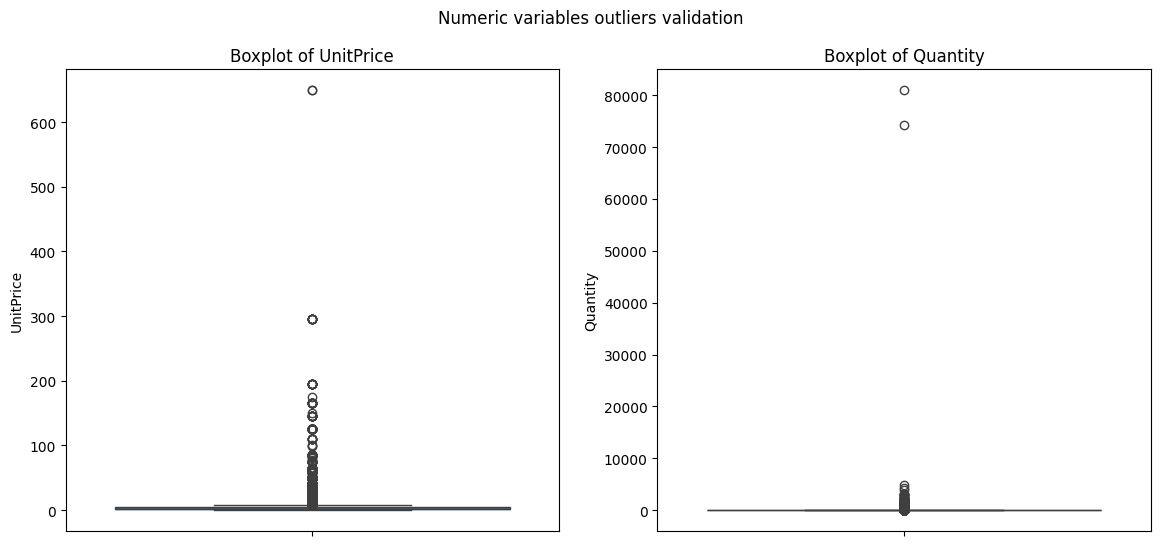

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
# Boxplot cho UnitPrice
sns.boxplot(data = ecom_df, y ='UnitPrice', ax=ax[0])
ax[0].set_title('Boxplot of UnitPrice')
# Boxplot cho Quantity
sns.boxplot(data = ecom_df, y = 'Quantity', ax=ax[1])
ax[1].set_title('Boxplot of Quantity')
plt.suptitle('Numeric variables outliers validation')
plt.show()

In [ ]:
# Define function để lọc ra outliers
def outlier_validation(df, col):
  Q3 = df[col].quantile(0.75)
  Q1 = df[col].quantile(0.25)
  IQR = Q3 - Q1
  upper_whisker = Q3 + 1.5*IQR
  lower_whisker = Q1 - 1.5*IQR
  outlier_mask = (df[col] > upper_whisker) | (df[col] < lower_whisker)
  return df[outlier_mask].sort_values(by=col)

In [ ]:
# Check outlier của UnitPrice
outlier_validation(ecom_df, 'UnitPrice')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
25063,538351,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,82,2010-12-10 15:17:00,8.47,anonymous_538351,United Kingdom
27238,538524,85135B,BLUE DRAGONFLY HELICOPTER,1,2010-12-13 09:35:00,8.47,anonymous_538524,United Kingdom
27239,538524,85135C,RED DRAGONFLY HELICOPTER,1,2010-12-13 09:35:00,8.47,anonymous_538524,United Kingdom
27240,538524,85136C,RED SHARK HELICOPTER,1,2010-12-13 09:35:00,8.47,anonymous_538524,United Kingdom
27140,538524,22942,CHRISTMAS LIGHTS 10 SANTAS,3,2010-12-13 09:35:00,8.47,anonymous_538524,United Kingdom
...,...,...,...,...,...,...,...,...
171178,551393,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-04-28 12:22:00,295.00,14973.0,United Kingdom
118769,546480,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-03-14 11:38:00,295.00,13452.0,United Kingdom
205759,554836,22655,VINTAGE RED KITCHEN CABINET,1,2011-05-26 16:25:00,295.00,13015.0,United Kingdom
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098.0,United Kingdom


In [ ]:
# Check outliers của Quantity
outlier_validation(ecom_df, 'Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
6933,536982,22867,HAND WARMER BIRD DESIGN,27,2010-12-03 14:27:00,5.06,anonymous_536982,United Kingdom
244011,558475,22499,WOODEN UNION JACK BUNTING,27,2011-06-29 15:58:00,4.96,anonymous_558475,United Kingdom
175360,551954,84879,ASSORTED COLOUR BIRD ORNAMENT,27,2011-05-05 12:13:00,1.69,14515.0,United Kingdom
464113,576078,17003,BROCADE RING PURSE,27,2011-11-13 16:22:00,0.39,14432.0,United Kingdom
168073,551011,72741,GRAND CHOCOLATECANDLE,27,2011-04-26 10:23:00,1.45,17090.0,United Kingdom
...,...,...,...,...,...,...,...,...
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087.0,United Kingdom
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135.0,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901.0,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom


Variable `UnitPrice` và `Quanity` có outliers rất rõ ràng.

Sau khi lọc và xem xét các outliers của 2 variables, không phát hiện giá trị bất thường, dữ liệu hợp lý với mô tả sản phẩm.

➡ Giữ lại outliers để phản ánh đúng hành vi mua hàng của khách hàng.

# Business Overview

Phân tích tổng quan hình hình kinh doanh của SuperStore

In [ ]:
# Bổ sung thêm cột thời gian giao dịch theo tháng, tính doanh thu và AOV
ecom_df['Period'] = ecom_df['InvoiceDate'].dt.to_period('M')
ecom_df['TotalSales'] = ecom_df['Quantity']*ecom_df['UnitPrice']
overview_df = (ecom_df.groupby('Period').agg(NumberofCustomers = ('CustomerID', 'nunique'),
                                            NumberofOrders = ('InvoiceNo', 'nunique'),
                                            MonthlySales = ('TotalSales', 'sum'))
                                            .assign(AOV = lambda df: df['MonthlySales']/df['NumberofOrders'])  # Tính thêm AOV thì MonthlySales và NumberofOrders mới trả về từ .agg()
                                            .reset_index())

Số lượng khách hàng qua từng tháng trong giai đoạn 01/12/2010 đến 09/12/2011

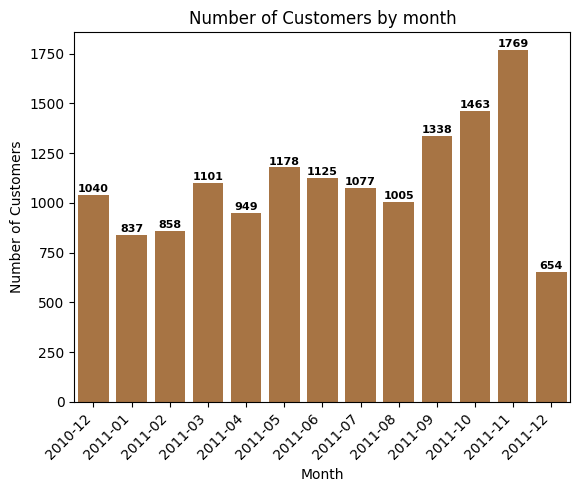

In [ ]:
g = sns.barplot(data=overview_df, x='Period', y='NumberofCustomers', color='#B87333')
plt.xlabel('Month')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by month')
for i, bar in enumerate(g.patches):
    h = bar.get_height()
    g.text(
        i, # bar index (x coordinate of text)
        h+30, # y coordinate of text
        '{}'.format(int(h)),  # y label
        ha='center',
        va='center',
        fontweight='bold',
        size=8)
plt.show()

Tăng trưởng doanh thu qua từng tháng

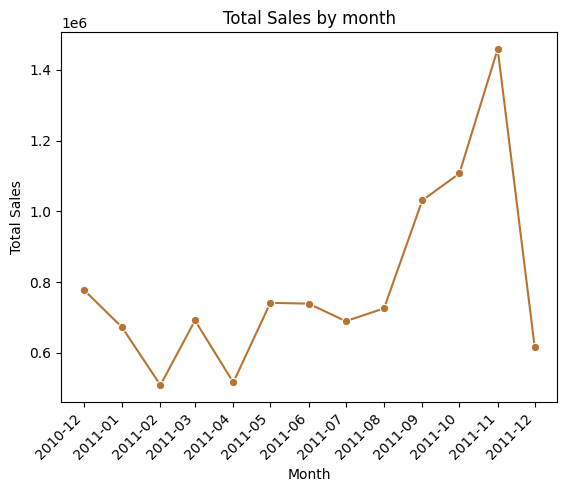

In [ ]:
g = sns.lineplot(x=overview_df['Period'].dt.to_timestamp(), y=overview_df['MonthlySales'], color='#B87333', marker="o")
plt.xlabel('Month')
g.set_xticks(overview_df['Period'].dt.to_timestamp())
g.set_xticklabels(overview_df['Period'].dt.to_timestamp().dt.strftime('%Y-%m'), rotation=45, ha='right')
plt.ylabel('Total Sales')
plt.title('Total Sales by month')
plt.show()

Tăng trường số lượng đơn hàng qua từng tháng

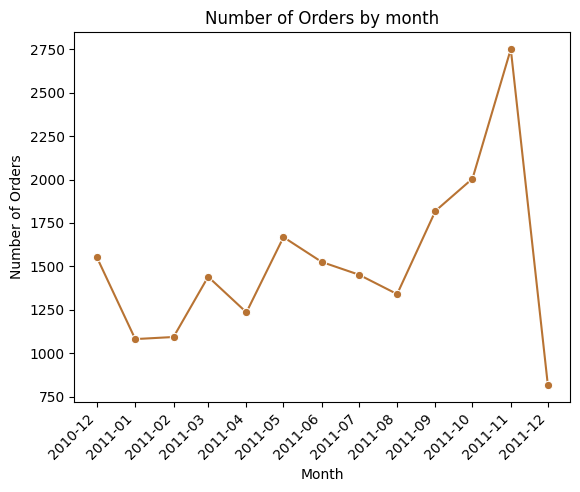

In [ ]:
g = sns.lineplot(x=overview_df['Period'].dt.to_timestamp(), y=overview_df['NumberofOrders'], color='#B87333', marker="o")
plt.xlabel('Month')
g.set_xticks(overview_df['Period'].dt.to_timestamp())
g.set_xticklabels(overview_df['Period'].dt.to_timestamp().dt.strftime('%Y-%m'), rotation=45, ha='right')
plt.ylabel('Number of Orders')
plt.title('Number of Orders by month')
plt.show()

Tăng trưởng AOV qua từng tháng

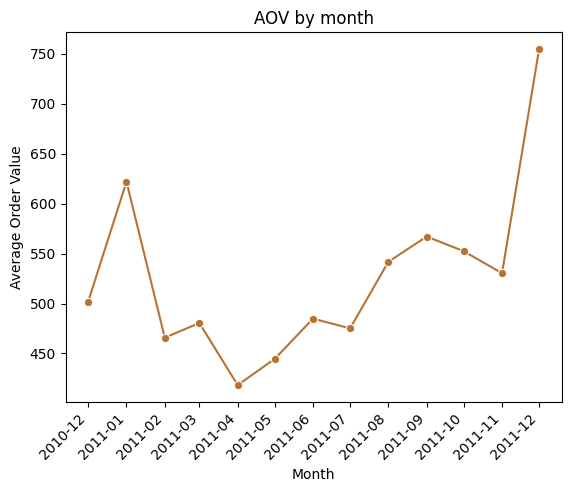

In [ ]:
g = sns.lineplot(x=overview_df['Period'].dt.to_timestamp(), y=overview_df['AOV'], color='#B87333', marker="o")
plt.xlabel('Month')
g.set_xticks(overview_df['Period'].dt.to_timestamp())
g.set_xticklabels(overview_df['Period'].dt.to_timestamp().dt.strftime('%Y-%m'), rotation=45, ha='right')
plt.ylabel('Average Order Value')
plt.title('AOV by month')
plt.show()

Kiểm tra sự tương quan giữa doanh thu và số lượng đơn hàng

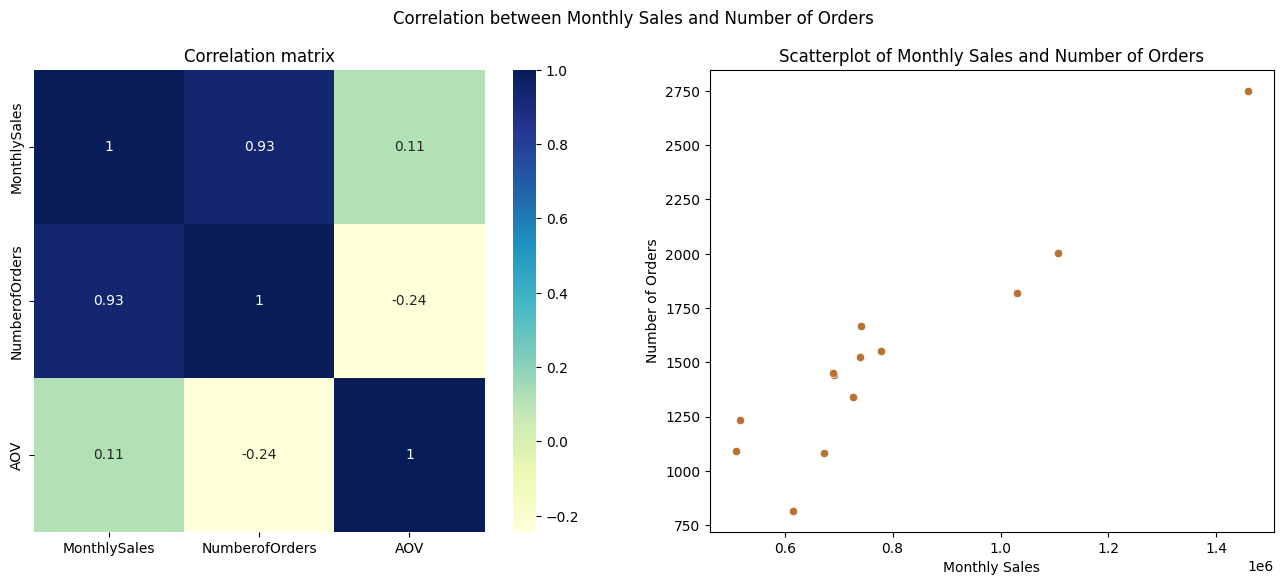

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
g0 = sns.heatmap(overview_df[['MonthlySales', 'NumberofOrders', 'AOV']].corr(), annot=True, cmap='YlGnBu', ax=ax[0])
g0.set_title('Correlation matrix')
g1 = sns.scatterplot(data=overview_df, x= 'MonthlySales', y='NumberofOrders', color='#B87333', ax=ax[1])
g1.set_xlabel('Monthly Sales')
g1.set_ylabel('Number of Orders')
g1.set_title('Scatterplot of Monthly Sales and Number of Orders')
plt.suptitle('Correlation between Monthly Sales and Number of Orders')
plt.show()

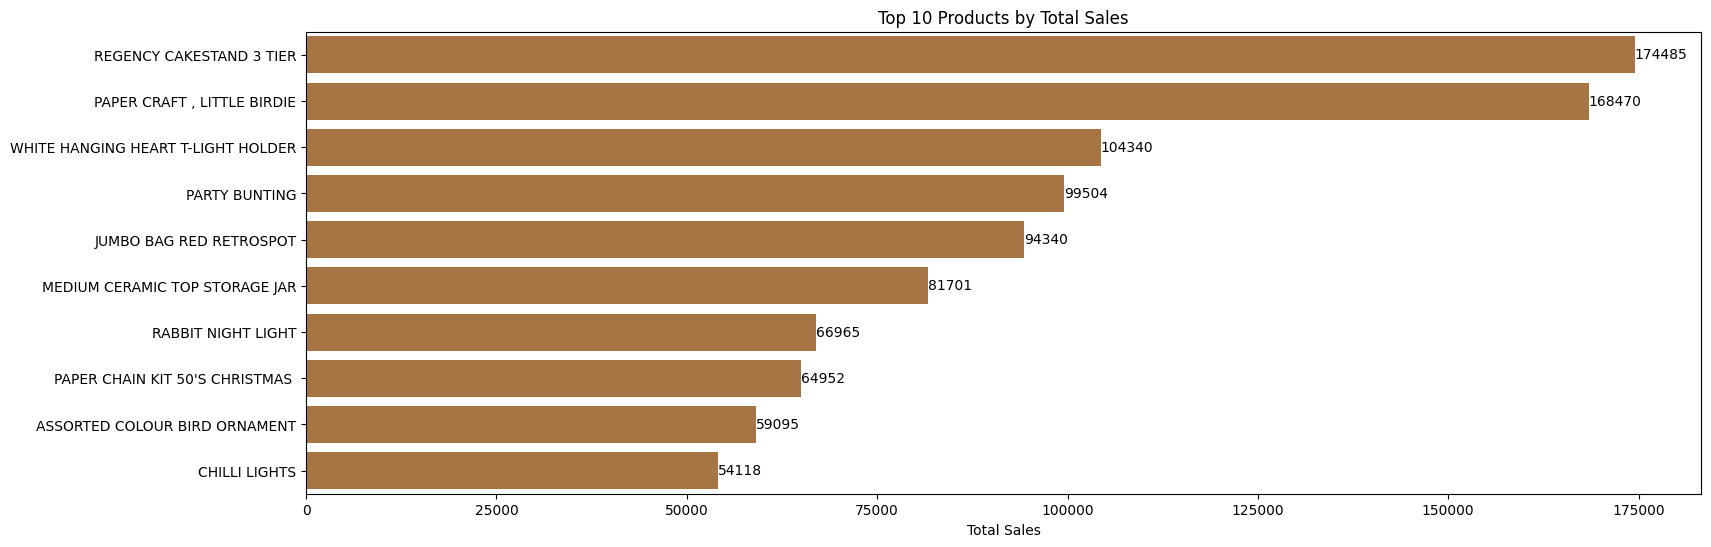

In [ ]:
# Top 10 best-performing products
top10_product_df = ecom_df.groupby(['StockCode', 'Description']).agg(TotalSales = ('TotalSales', 'sum')).sort_values(by='TotalSales', ascending=False).reset_index().head(10)
plt.figure(figsize=(18,6))
g = sns.barplot(data=top10_product_df, x='TotalSales', y='Description', color='#B87333')
plt.xlabel('Total Sales')
plt.ylabel('')
plt.title('Top 10 Products by Total Sales')
for container in g.containers:
    g.bar_label(container, fmt='%.0f', fontsize=10)
plt.show()

# RFM Analysis



## Change the format of `segment_def_df`
Vì bảng `segment_def_df` đang được nested, cần unnest thành dạng long-formated table để merge với `rfm_df`

Kết quả: bảng `rfm_definition_df` chứa định nghĩa về segment cho từng rfm_score

### Option 1

In [ ]:
# Chuyển df thành dạng dictionary {Segment: 'RFM_Score'}
rfm_dict = {}
for index in segment_def_df.index:
    rfm_dict[segment_def_df.loc[index, 'Segment']] = segment_def_df.loc[index, 'RFM Score']
# Vì 'RFM_Score' đang là một chuỗi chứa các scores cách nhau bởi dấu ',' nên cần đưa về dạng list of int
for key, value in rfm_dict.items():
  x = value.split(',')
  rfm_dict[key] = [int(i) for i in x]
# Tạo 2 list: rfm_score_list chứa các score và segment_list chứa các tên segment tương ứng
segment_list = []
rfm_score_list = []
for key, value in rfm_dict.items(): # Đối với mỗi cặp key-value
  counter = 0
  while counter < len(value):
    segment_list.append(key) # Thêm liên tục key vào segment_list cho đến khi số key bằng số element của value hiện tại thì chuyển sang cặp key-value tiếp theo
    counter = counter + 1
  for element in value:
    rfm_score_list.append(element) # Thêm liên tục từng element trong value vào rfm_score_list cho đến hết thì chuyển sang cặp key-value tiếp theo
rfm_df_long_1 = pd.DataFrame({'Segment':segment_list, 'RFM_Score':rfm_score_list})

In [ ]:
rfm_df_long_1

,Segment,RFM_Score
0,Champions,555
1,Champions,554
2,Champions,544
3,Champions,545
4,Champions,454
...,...,...
120,Lost Customers,112
121,Lost Customers,121
122,Lost Customers,131
123,Lost Customers,141


### Option 2

In [ ]:
rfm_map_df = segment_def_df.copy()
# Tách các giá trị RFM Score từ str thành list of int
rfm_map_df['RFM Score'] = rfm_map_df['RFM Score'].apply(lambda x: [int(score.strip()) for score in x.split(',')])
# Dùng explode để mở từng giá trị trong list thành 1 row
rfm_df_long_2 = rfm_map_df.explode('RFM Score').reset_index(drop=True)
# Format lại tên cột
rfm_df_long_2.rename(columns={'RFM Score': 'RFM_Score'}, inplace=True)

In [ ]:
rfm_df_long_2

,Segment,RFM_Score
0,Champions,555
1,Champions,554
2,Champions,544
3,Champions,545
4,Champions,454
...,...,...
120,Lost Customers,112
121,Lost Customers,121
122,Lost Customers,131
123,Lost Customers,141


### Check kết quả 2 cách

In [ ]:
# Kiểm tra rfm_long_df_1 và rfm_long_df_2 có giống nhau không
## Do column được mở rộng bằng explode có dtype là Object nên chuyển sang int
rfm_df_long_2['RFM_Score'] = rfm_df_long_2['RFM_Score'].astype(int)
## equals kiểm tra cả từng value trong df và dtypes
rfm_df_long_1.equals(rfm_df_long_2)

True

In [ ]:
rfm_definition_df = rfm_df_long_2.copy()

## Calculate the metrics Recency, Frequency, Monetary

In [ ]:
# Ngày thực hiện phân tích giả định
assumed_analysis_date = pd.to_datetime('2011-12-31')

In [ ]:
# Tính TotalSales = Quantity*UnitPrice
ecom_df['TotalSales'] = ecom_df['Quantity']*ecom_df['UnitPrice']

In [ ]:
# Tạo bảng RFM ban đầu
rfm_df = ecom_df.groupby(['CustomerID','Country']).agg(
                                                        Recency = ('InvoiceDate', lambda x: (assumed_analysis_date - x.max()).days),
                                                        Frequency = ('InvoiceNo', 'nunique'),
                                                        Monetary = ('TotalSales', 'sum')
                                                        ).reset_index()

## Observe customer distribution by Country

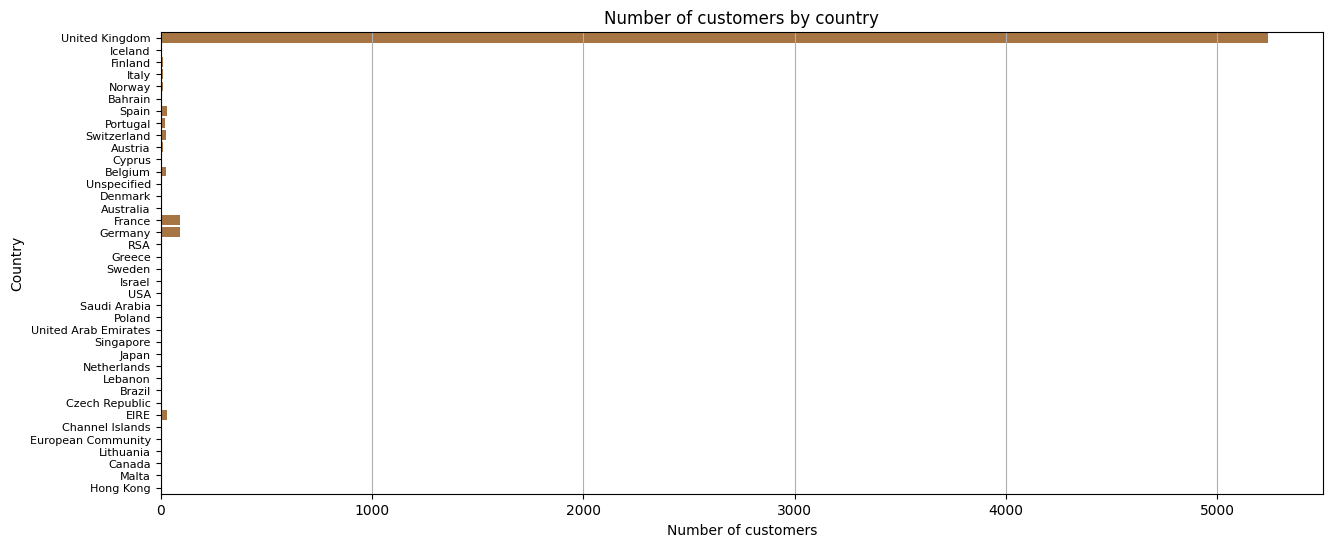

In [ ]:
# Quan sát phân bổ khách hàng theo khu vực địa lý
plt.figure(figsize=(15,6))
sns.countplot(data=rfm_df, y='Country', color='#B87333')
plt.yticks(fontsize=8)
plt.xlabel('Number of customers')
plt.ylabel('Country')
plt.grid(axis='x')
plt.title('Number of customers by country')
plt.show()

In [ ]:
# Tính số lượng khách hàng từng khu vực
num_uk = rfm_df[rfm_df['Country'] == 'United Kingdom']['CustomerID'].nunique()
num_other = rfm_df[rfm_df['Country'] != 'United Kingdom']['CustomerID'].nunique()

In [ ]:
# Tính doanh thu khách hàng từng khu vực
uk_sales = rfm_df[rfm_df['Country'] == 'United Kingdom']['Monetary'].sum()
other_sales = rfm_df[rfm_df['Country'] != 'United Kingdom']['Monetary'].sum()

In [ ]:
# Tính số lượng đơn hàng từng khu vực
uk_orders = rfm_df[rfm_df['Country'] == 'United Kingdom']['Frequency'].sum()
other_orders = rfm_df[rfm_df['Country'] != 'United Kingdom']['Frequency'].sum()

In [ ]:
# Define a function to draw a piechart
def pie_chart(uk_var, non_uk_var, title):
  labels = ['United Kingdom', 'Other Countries']
  sizes = [uk_var, non_uk_var]
  # Custom labels
  def make_autopct(values):
      def my_autopct(pct):
          total = sum(values)
          val = int(round(pct*total/100.0))
          return f"{val:,}\n({pct:.1f}%)"
      return my_autopct
  # Colors cho wedge
  colors = ["#B87333", "#F4F4DC"]
  # Plot
  fig, ax = plt.subplots(figsize=(6,6))
  wedges, texts, autotexts = ax.pie(
      sizes,
      labels=labels,
      autopct=make_autopct(sizes),
      startangle=90,
      textprops={'fontsize':12},
      colors=colors
  )
  # Chỉnh màu label và autopct
  texts[0].set_color("#B87333")
  texts[1].set_color("#B87333")
  autotexts[0].set_color("#F4F4DC")
  autotexts[1].set_color("#B87333")
  # Title
  ax.set_title(title, fontsize=14, fontweight='bold')
  plt.show()

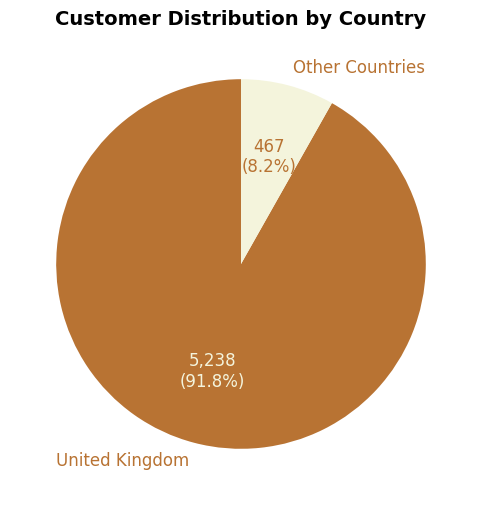

In [ ]:
pie_chart(num_uk, num_other, "Customer Distribution by Country")

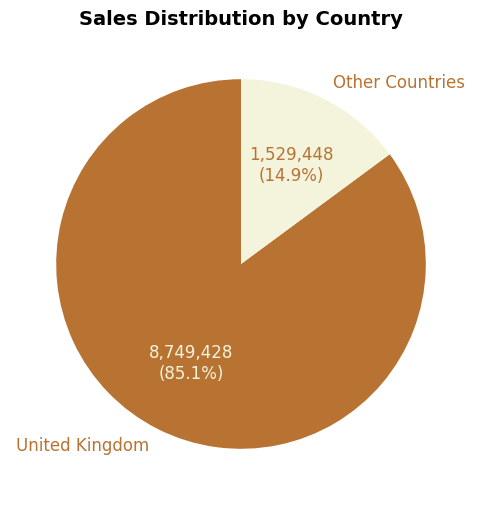

In [ ]:
pie_chart(uk_sales, other_sales, "Sales Distribution by Country")

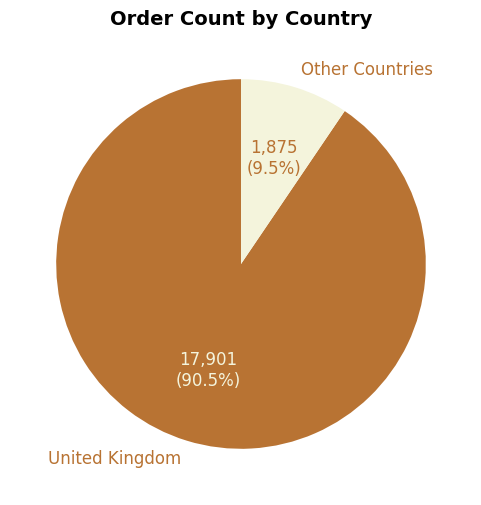

In [ ]:
pie_chart(uk_orders, other_orders, "Order Count by Country")

Quan sát thấy số lượng khách hàng tập trung rất nhiều ở UK ➡ Tách UK ra thành 1 đối tượng phân tích RFM riêng

In [ ]:
# Tạo bảng RFM riêng cho UK
uk_rfm_df = rfm_df[rfm_df['Country'] == 'United Kingdom']
# Tạo bảng RFM riêng cho các quốc gia khác
other_rfm_df = rfm_df[rfm_df['Country'] != 'United Kingdom']

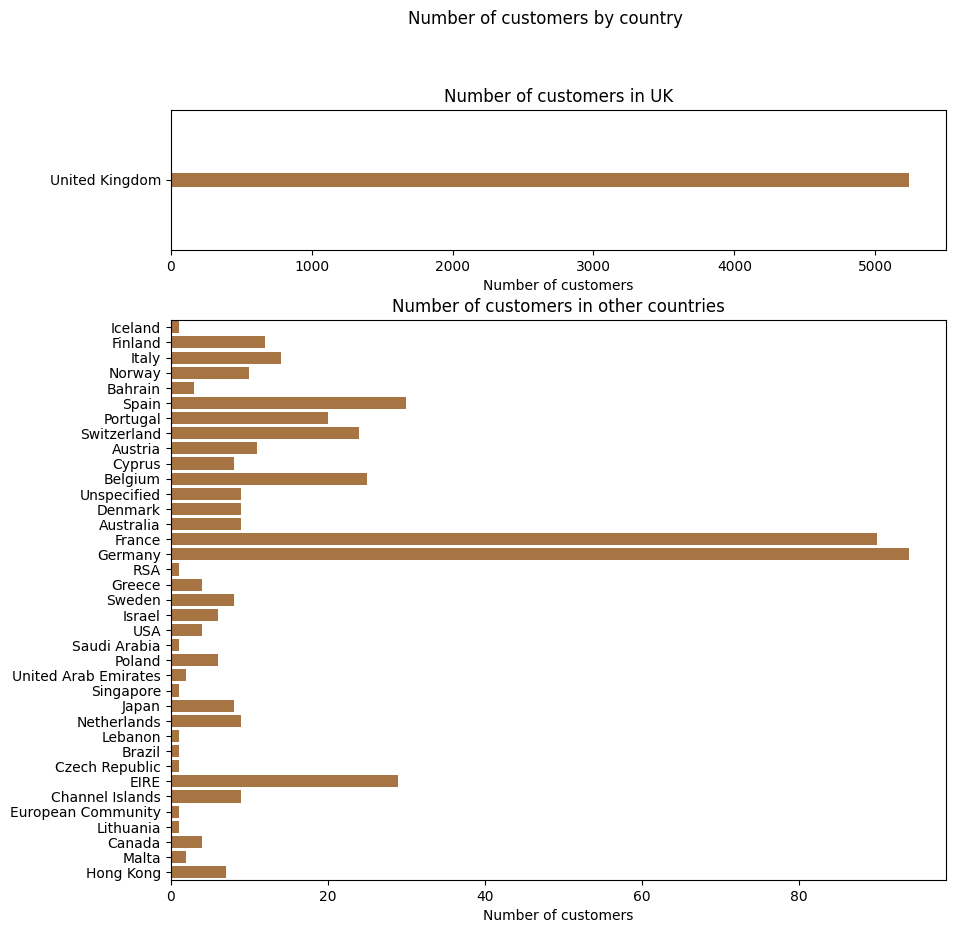

In [ ]:
# Check lại phân bổ khách hàng
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10), gridspec_kw={'height_ratios': [1, 4]})
# Vẽ countplot cho UK
sns.countplot(data=uk_rfm_df, y='Country', ax=ax[0], width=0.1, color='#B87333')
ax[0].set_xlabel('Number of customers')
ax[0].set_title('Number of customers in UK')
ax[0].set_ylabel('')
# Vẽ countplot cho các quốc gia còn lại
sns.countplot(data=other_rfm_df, y='Country', ax=ax[1], color='#B87333')
ax[1].set_xlabel('Number of customers')
ax[1].set_title('Number of customers in other countries')
ax[1].set_ylabel('')
plt.suptitle('Number of customers by country')
plt.show()

➡ Thực hiện phân tích RFM riêng cho thị trường UK và chung cho các nước còn lại

Công ty SuperStore là một công ty bán lẻ trên toàn cầu - Global. Nên công ty có rất nhiều khách hàng.
Nhân dịp giáng sinh và năm mới, phòng Marketing muốn chạy các chiến dịch marketing để tri ân khách hàng đã ủng hộ công ty suốt thời gian qua. Cũng như khai thác các khách có tiềm năng trở thành khách hàng trung thành.

Tuy nhiên phòng Marketing vẫn chưa phân nhóm cho từng khách hàng của năm nay được vì tập dữ liệu quá lớn nên không thể xử lý bằng tay như các năm trước, nên nhờ Phòng Phân tích dữ liệu hỗ trợ triển khai một bài toán phân loại phân khúc của từng khách hàng để triển khai từng chương trình marketing phù hợp với từng nhóm khách hàng.

Giám đốc Marketing cũng có đề xuất phương án sử dụng mô hình RFM, tuy nhiên trước đây khi quy mô công ty nhỏ, team có thể tự tính và phân loại bằng excel. Hiện tại lượng data quá lớn nên mong muốn Phòng dữ liệu xây dựng luồng triển khai đánh giá Segmentation thông qua lập trình Python.

## RFM Analyze

Tạo hàm vẽ histogram cho từng chỉ số R, F, M

In [ ]:
def histogram_plot(df, suptitle):
  recency = df['Recency']
  frequency = df['Frequency']
  monetary = df['Monetary']
  data_dict = {
      'Recency': recency,
      'Frequency': frequency,
      'Monetary': monetary
  }
  # Tạo figure với 3 subplots nằm ngang
  fig, axes = plt.subplots(1, 3, figsize=(18,5))
  for ax, (title, data) in zip(axes, data_dict.items()):
      # Tính histogram để lấy bin_edges
      counts, bin_edges = np.histogram(data, bins=20)
      # Vẽ histogram
      sns.histplot(data=data, bins=bin_edges, ax=ax, color='#B87333', edgecolor='black')
      # Tạo nhãn bin dạng: "start–end"
      bin_labels = [f"{int(bin_edges[i])}–{int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]
      bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges)-1)]
      # Gán xticks và xticklabels
      ax.set_xticks(bin_centers)
      ax.set_xticklabels(bin_labels, rotation=45, ha='right', fontsize=8)
      # Đặt tiêu đề cho subplot
      ax.set_title(title)
      ax.set_xlabel(title)
      ax.set_ylabel("")
  # Tự động chỉnh layout để không bị chồng nhãn
  plt.tight_layout()
  plt.suptitle(suptitle, y=1.03)
  plt.show()

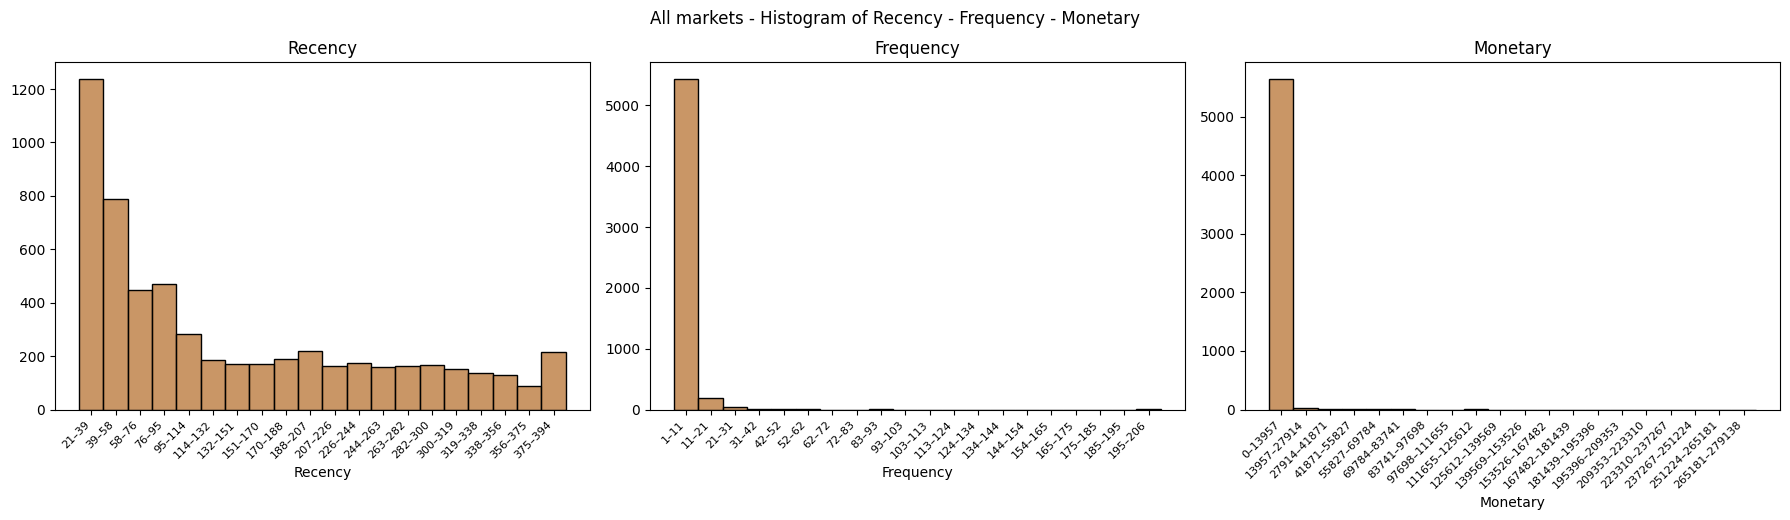

In [ ]:
# Phân phối R,F,M của tất cả các thị trường
histogram_plot(rfm_df, 'All markets - Histogram of Recency - Frequency - Monetary')

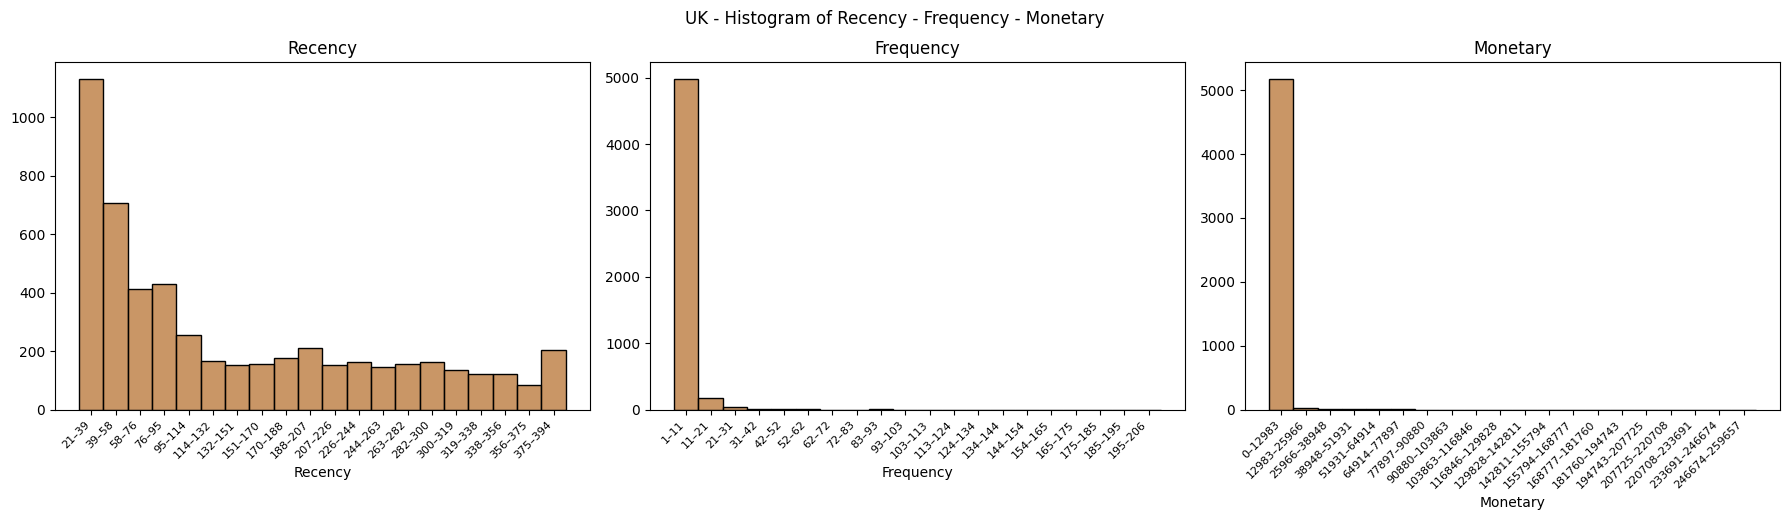

In [ ]:
# Phân phối R,F,M của riêng UK
histogram_plot(uk_rfm_df, 'UK - Histogram of Recency - Frequency - Monetary')

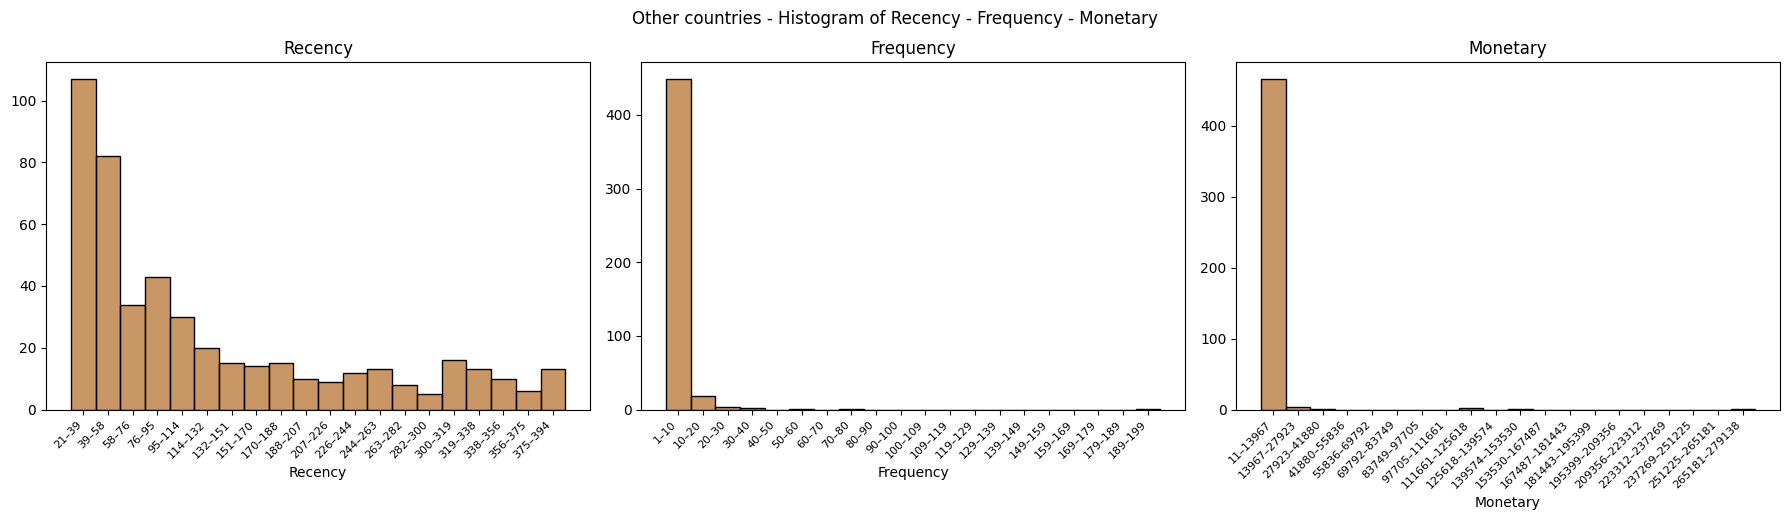

In [ ]:
# Phân tích R,F,M của các nước còn lại
histogram_plot(other_rfm_df, 'Other countries - Histogram of Recency - Frequency - Monetary')

In [ ]:
# Tạo function tính rfm score
def rfm_score_calculator(df):
  df = df.copy() # Tránh lỗi SettingWithCopyWarning - Function trả về bản sao đã qua xử lý, không thay đổi bản gốc của df
  df['R_Score'] = pd.qcut(x=df['Recency'].rank(method='first'), q=5, labels=[5,4,3,2,1])
  df['F_Score'] = pd.qcut(x=df['Frequency'].rank(method='first'), q=5, labels=[1,2,3,4,5])
  df['M_Score'] = pd.qcut(x=df['Monetary'].rank(method='first'), q=5, labels=[1,2,3,4,5])
  df['RFM_Score'] = (df['R_Score'].astype(str) + df['F_Score'].astype(str) + df['M_Score'].astype(str)).astype(int)
  df['Segment'] = df['RFM_Score'].map(rfm_definition_df.set_index('RFM_Score')['Segment'])
  return df

In [ ]:
# Tính rfm score cho thị trường UK và các nước còn lại
uk_segmentation_df = rfm_score_calculator(uk_rfm_df)
other_country_segmentation_df = rfm_score_calculator(other_rfm_df)

In [ ]:
# Chuyển đổi sang OLAP để visualize
uk_olap_df = uk_segmentation_df.groupby('Segment').agg(NumberofCustomers = ('CustomerID', 'count')).reset_index().sort_values(by='NumberofCustomers', ascending=False)
other_country_olap_df = other_country_segmentation_df.groupby('Segment').agg(NumberofCustomers = ('CustomerID', 'count')).reset_index().sort_values(by='NumberofCustomers', ascending=False)

Do mục tiêu phân tích là tri ân khách hàng đã đồng hành cùng công ty trong năm qua, đồng thời thúc đẩy sự gắn bó của các khách hàng tiềm năng để biến họ thành khách hàng trung thành, các phân khúc tiếp tục được ra làm 3 nhóm với từng hành động cụ thể.

Nhóm 1 gồm: 'Champions', 'Loyal Customers', 'Potential Loyalists', 'Promising' - là nhóm đối tượng ưu tiên của chiến dịch

Nhóm 2 gồm: 'Need Attention', 'New Customers' - là nhóm cần theo dõi thêm

Nhóm 3 gồm các phân khúc còn lai - là nhóm tạm thời bỏ qua

In [ ]:
# Tạo nhóm màu theo từng nhóm ưu tiên
color_dict = {}
for seg in uk_olap_df['Segment']:
  if seg in ['Champions', 'Loyal Customers', 'Potential Loyalists', 'Promising']:
    color_dict[seg] = '#5b3614'
  elif seg in ['Need Attention', 'New Customers']:
    color_dict[seg] = '#B87333'
  else:
    color_dict[seg] = '#f2e3d7'

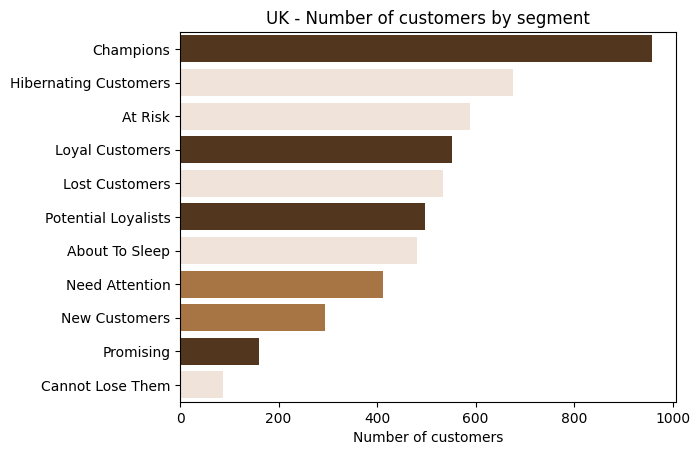

In [ ]:
sns.barplot(data=uk_olap_df, x='NumberofCustomers', y='Segment', hue = 'Segment', legend=False, palette=color_dict)
plt.xlabel('Number of customers')
plt.ylabel('')
plt.title('UK - Number of customers by segment')
plt.show()

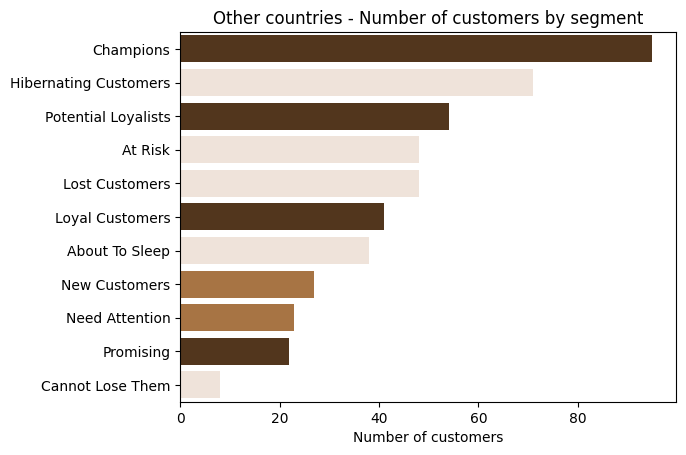

In [ ]:
# Chia theo theo nhóm segment
sns.barplot(data=other_country_olap_df, x='NumberofCustomers', y='Segment', hue = 'Segment', legend=False, palette=color_dict)
plt.xlabel('Number of customers')
plt.ylabel('')
plt.title('Other countries - Number of customers by segment')
plt.show()

# Link bài báo cáo: https://drive.google.com/file/d/1UTGqwk_CRItb29b9xiEpNjmNoF2F6mlJ/view?usp=drive_link